In [1]:
%%capture 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

!pip install Biopython
!rm -r iFeature
!rm -r spaan
!git clone https://github.com/Superzchen/iFeature
!git clone https://github.com/nicolagulmini/spaan

from Bio import SeqIO
import numpy
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [2]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [4]:
# dataset
positive = list(SeqIO.parse("./spaan/data/25_similarity/positive/adhesins.fasta", "fasta"))
negative = list(SeqIO.parse("./spaan/data/25_similarity/negative/non_adhesins.fasta", "fasta"))

MAXLEN = 1000 # do some preprocessing to choose this
    
aa_list = [
    'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'X', 'B', 'U', 'Z'
    ]

def seq_to_ind(seq):
    ind_seq = []
    for aa in seq:
        ind_seq.append(aa_list.index(aa)+1)
    return pad_sequences([ind_seq], maxlen=MAXLEN, padding='post', truncating='post')[0]

X_seq = numpy.array([seq_to_ind(el.seq) for el in positive+negative])

In [5]:
print('data sequences shape:', X_seq.shape)

y_pos = numpy.ones(len(positive))
y_neg = numpy.zeros(len(negative))
y = numpy.concatenate((y_pos, y_neg), axis=0)

print('y shape:', y.shape)

data sequences shape: (7424, 1000)
y shape: (7424,)


In [6]:
# permutation
c = numpy.random.permutation(numpy.arange(y.shape[0]))

y = y[c]
X_seq = X_seq[c] 

In [7]:
# remember: standardization or scaling AFTER train-test split, otherwise there's data leakage!!!

X_seq_train = X_seq[:int(X_seq.shape[0]*.5)]
X_seq_val = X_seq[int(X_seq.shape[0]*.5):int(X_seq.shape[0]*.75)]
X_seq_test = X_seq[int(X_seq.shape[0]*.75):]

y_train = y[:int(y.shape[0]*.5)]
y_val = y[int(y.shape[0]*.5):int(y.shape[0]*.75)]
y_test = y[int(y.shape[0]*.75):]

In [8]:
embed_dim = 32  # Embedding size for each token
num_heads = 5  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(MAXLEN,))
embedding_layer = TokenAndPositionEmbedding(MAXLEN, len(aa_list)+1, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="sigmoid")(x)
x = layers.Dense(20, activation="sigmoid")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [9]:
model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)

history = model.fit(
    x=X_seq_train, 
    y=y_train,
    batch_size=32,
    epochs=200,
    verbose=1,
    validation_data=(X_seq_val, y_val),
    shuffle=True,
    callbacks=[tf.keras.callbacks.EarlyStopping(
    restore_best_weights=False,
    patience=5
        )]
)

Epoch 1/200
116/116 [==============================] - 649s 6s/step - loss: 0.5776 - accuracy: 0.7293 - val_loss: 0.4947 - val_accuracy: 0.7980
Epoch 2/200
116/116 [==============================] - 650s 6s/step - loss: 0.4562 - accuracy: 0.8192 - val_loss: 0.4278 - val_accuracy: 0.8303
Epoch 3/200
116/116 [==============================] - 643s 6s/step - loss: 0.3605 - accuracy: 0.8594 - val_loss: 0.3308 - val_accuracy: 0.8745
Epoch 4/200
116/116 [==============================] - 665s 6s/step - loss: 0.3179 - accuracy: 0.8807 - val_loss: 0.2680 - val_accuracy: 0.8987
Epoch 5/200
116/116 [==============================] - 676s 6s/step - loss: 0.2909 - accuracy: 0.8920 - val_loss: 0.3024 - val_accuracy: 0.8825
Epoch 6/200
116/116 [==============================] - 691s 6s/step - loss: 0.2776 - accuracy: 0.8930 - val_loss: 0.2615 - val_accuracy: 0.8976
Epoch 7/200
116/116 [==============================] - 696s 6s/step - loss: 0.2777 - accuracy: 0.8979 - val_loss: 0.2568 - val_accuracy:

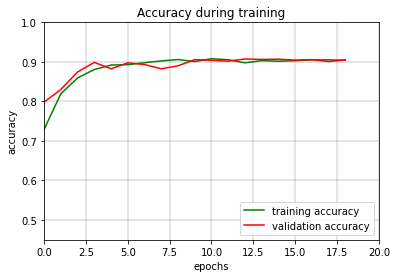

In [10]:
plt.title('Accuracy during training')
plt.plot(range(len(history.history['loss'])), history.history['accuracy'], label='training accuracy', color='green')
plt.plot(range(len(history.history['loss'])), history.history['val_accuracy'], label='validation accuracy', color='red')
plt.grid(color='gray', linewidth=.4)

plt.legend(loc="lower right")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.xlim(0, len(history.history['loss'])+1)
plt.ylim(.45, 1.)
plt.savefig('acc.png')

In [13]:
model.evaluate(X_seq_test, y_test)

58/58 [==============================] - 146s 2s/step - loss: 0.2307 - accuracy: 0.9143


[0.23065918684005737, 0.9143319129943848]